__Forward encoding model based on Pim Mostert Decoding toolbox__

Alexis Pérez Bellido (2022)

In [65]:
%matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73
import sys
import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
#print(sys.path)

Decoding modules

In [66]:
path_utils = '/Users/alex/Library/CloudStorage/OneDrive-UniversitatdeBarcelona/Projects/Condcision/Group_level_analyses/Beh_analyses/EEG_condcision_CJ/helper_funcs' 
sys.path.append(path_utils)

In [67]:
path = '/Users/alex/Library/CloudStorage/OneDrive-UniversitatdeBarcelona/TOOLBOXES/decoding-toolbox/data/'
path_ori_data = path + 'testdata_orientation.mat'

Loading & preparing orientation data

In [68]:
ori_data = mat73.loadmat(path_ori_data)

In [213]:
Y = ori_data['Y']
X = ori_data['X']
time = ori_data['time']
label = ori_data['label']

In [70]:
phi = X * (180/8);   # Presented orientation in degrees
binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity

numF = Y.shape[0];
numT = Y.shape[1];
numN = Y.shape[2];

In [71]:
# No time dimension (We only select one point as example)
sel_t = np.where(time >=.2)[0][0];

Creating and saving dat

In [72]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G);
nConds = CONDS.size
nfold = 2
FoldsIdx = dt.CreateFolds(G, Y, nfold)

In [74]:
dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

In [75]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(dat['phi_train'], cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

# for comparing this script and the matlab one
import scipy
path_folds_data = '/Users/alex/Library/CloudStorage/OneDrive-UniversitatdeBarcelona/Projects/Condcision/Group_level_analyses/Beh_analyses/EEG_condcision_CJ/folds.mat'

mat = scipy.io.loadmat(path_folds_data)

idx_Train = mat['folds'][0][0].T
idx_Test =mat['folds'][1][0][0].T

#Folds_ori = Folds.copy()
dat = {}
dat['X_train'] = G[idx_Train-1] # -1 to correct for matlab to python indexes
dat['X_test'] = G[idx_Test-1]
dat['Y_train'] = np.squeeze(Y[:,sel_t, idx_Train-1])
dat['Y_test'] = np.squeeze(Y[:,sel_t, idx_Test-1])
dat['phi_train'] = phi[idx_Train-1]
dat['phi_test'] = phi[idx_Test-1]

Create design matrix

numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(dat['phi_train'], cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

Training encoding model

In [76]:
cfg = dict()
cfg['gamma'] = 0.01
cfg['demean'] = True
cfg['returnPattern'] = True
decoder = dt.train_encoder(design, dat['Y_train'], cfg)

Testing the encoding model

In [77]:
cfg = dict()
cfg['demean'] = 'traindata'
Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg)

__Preparing data for plotting results__

In [78]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)


Re-alligning predictions for trials with identical orientation

In [79]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == (ic+1))] = np.roll(Xhat[:,np.where(dat['X_test'] == (ic+1))], -ic, axis = 0)

In [80]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)

In [81]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [82]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.28435446698274447

Getting mean orientation values for each stimulus bin

In [63]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == (ic+1))[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

In [64]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2))

__Preparing crossvalidation procedure__

In [299]:
import DecToolbox as dt
from importlib import reload  # Python 3.4+
reload(dt)

<module 'DecToolbox' from '/Users/alex/Library/CloudStorage/OneDrive-UniversitatdeBarcelona/Projects/Condcision/Group_level_analyses/Beh_analyses/EEG_condcision_CJ/DecToolbox.py'>

In [139]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

In [170]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [178]:
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [179]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1)], axis = 1)

Re-alligning predictions for trials with identical orientation

In [180]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1)] = np.roll(Xhat[:,G == (ic+1)], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == (ic+1)], axis = 1)

In [181]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [182]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.01732998930538348

Getting mean orientation values for each stimulus bin

In [183]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == (ic+1)] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

In [268]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


ValueError: x and y can be no greater than 2D, but have shapes (8,) and (8, 8, 211, 211)

__Temporal dimension decoding__

In [195]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
    
    

In [196]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1),:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [198]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:] = np.roll(Xhat[:,G == (ic+1),:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :], axis = 1)

In [230]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()
ax.set_xtickslabels(time)
ax.set_Yticklabels(x_centeredlabels.astype(str))


AttributeError: 'AxesSubplot' object has no attribute 'set_xtickslabels'

__Crossmodal temporal generalization decoding__

In [300]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)

In [246]:
m = np.zeros((numC,numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == (ic+1),:,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [247]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:, :] = np.roll(Xhat[:,G == (ic+1),:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :, :], axis = 1)

Plotting diagonal values

In [267]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7f81ae698a50> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7f81ae7abf30> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7f81aedaaef0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7f81c9df42c0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <_NSViewBackingLayer: 0x7f81ae698a50> contents scale of 1 - updating layer to match.


Correlation between actual and predicted orientation values

In [292]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = 'gaussian', vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()

In [241]:
def CV_TG_encoder(design, Y, sel_t, cfg, FoldsIdx):

    numC = design.shape[0]
    numT = Y.shape[1]
    numN = Y.shape[2]

    # decode numT X numT
    Xhat = np.zeros([numC,numN, numT])
    Xhat_centered = 0*Xhat.copy()

    nfold = np.size(FoldsIdx)

    for ifold in range(nfold):
        # Training encoder
        dat = dict()
        dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['train_index']])
        idesign = design[:,FoldsIdx[ifold]['train_index']]
        dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['test_index']])

        if 'cfgE' not in cfg:
            cfgE = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        else:
            cfgE = cfg['cfgE']

        decoder = dt.train_encoder(idesign, dat['Y_train'], cfgE)

        if 'cfgD' not in cfg:
            cfgD = {'demean' : 'traindata'}
        else:
            cfgD = cfg['cfgD']
        # Testing encoding model on all the time points of test data
        for it in range(numT):
            dat['Y_test'] = np.squeeze(Y[:,it, FoldsIdx[ifold]['test_index']])
            Xhat[:,FoldsIdx[ifold]['test_index'],it] = dt.test_encoder( decoder, dat['Y_test'], cfgD) 
    
    return Xhat

In [169]:
def CV_encoder(design, Y, sel_t, cfg, FoldsIdx):

    numC = design.shape[0]
    numN = Y.shape[2]

    Xhat = np.zeros([numC,numN])
    Xhat_centered = 0*Xhat.copy()

    nfold = np.size(FoldsIdx)

    for ifold in range(nfold):
        # Output matrix
        dat = dict()
        dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['train_index']])
        idesign = design[:,FoldsIdx[ifold]['train_index']]
        dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['test_index']])

        if 'cfgE' not in cfg:
            cfgE = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        else:
            cfgE = cfg['cfgE']

        decoder = dt.train_encoder(idesign, dat['Y_train'], cfgE)

        if 'cfgD' not in cfg:
            cfgD = {'demean' : 'traindata'}
        else:
            cfgD = cfg['cfgD']


        Xhat[:,FoldsIdx[ifold]['test_index']] = dt.test_encoder( decoder, dat['Y_test'], cfgD) 
    
    return Xhat

Getting mean orientation values for each stimulus bin

# Plotting results

In [ ]:
# Creating dat containing test and train indexes
nfold = 2

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfold,shuffle=False)
CrossValIdx = [None] * nfold
i = 0
for train_index, test_index  in  skf.split(X = np.zeros(numN), y = X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    CrossValIdx[i] = { 'train_index': train_index, 'test_index': test_index}
    i += 1

 X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
 Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
 phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]

 X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
 Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
 phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [ ]:

 X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
 Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
 phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]

 X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
 Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
 phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [225]:
G[dat[0].astype(int)]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6

In [229]:
dat = [np.array([])]*nfold

for iCond in range(nConds):
    # Find indexes
    indx = np.where(G == CONDS[iCond])[0]
    n_indx = indx.size 
    # Shuffle indexes
    indx = np.random.permutation(indx)
    # Distribute across dat
    nelemxfold = np.floor(indx.size/nfold)
    groupNumber = np.repeat(np.arange(0,nfold), nelemxfold)

    for iFold in range(nfold):
        dat[iFold] = np.append(dat[iFold], indx[np.where(groupNumber == iFold)])

 

In [228]:
 indx[np.where(groupNumber == iFold)]

array([697, 149, 699, 463, 742, 677, 351, 758, 520,  25, 584,  20, 139,
        77,  81, 193,  64,  42, 703, 450, 381, 364, 654, 113, 459, 305,
       746, 192, 260, 590, 147, 556, 551,  45, 481, 541, 236, 488, 519,
       711,  83, 663, 140,   3, 306, 152, 494])

In [227]:
dat

[array([229., 753., 264., 389., 111., 482., 376., 371., 107., 122., 591.,
        289., 570., 667., 658., 335., 698., 356., 690., 721., 737., 245.,
        639., 391., 212., 527., 141., 329., 511., 752., 713.,   1., 759.,
          7., 230., 413., 440., 708., 295., 598., 224., 521.,  47., 747.,
        615., 480., 745., 384.,  91., 497., 201., 668.,  41., 474., 431.,
        522., 200., 231., 128., 729., 715.,  50.,  86., 515., 422.,  49.,
        244.,  23., 634., 353., 680., 661., 562.,  76., 673., 623., 287.,
        605., 185., 744., 423., 266., 650., 689., 580., 225., 484., 164.,
        679., 312., 263.,  78., 716., 347., 446., 235., 688., 135., 672.,
        608., 537., 561., 378., 341., 576., 348.,  63., 565.,  75., 596.,
        617., 575., 286.,  65., 362.,  16., 400., 311., 199., 660., 425.,
        109., 726., 490., 404., 571., 426., 124.,  21., 741., 409., 621.,
        340., 346., 134., 683., 105., 345.,  33.,  67., 232., 401., 665.,
        651., 647., 485., 518., 643., 

(array([95., 94., 95.,  0., 94., 96.,  0., 95., 96., 95.]),
 array([  0.  ,  15.75,  31.5 ,  47.25,  63.  ,  78.75,  94.5 , 110.25,
        126.  , 141.75, 157.5 ]),
 <BarContainer object of 10 artists>)

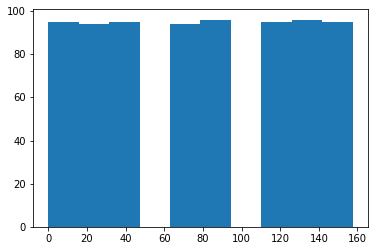

In [39]:
plt.hist(phi)

In [29]:
nfold = 2

In [42]:
np.asarray(time >=.2).nonzero()

(array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]),)

120